# DSL 2022 winter call
## Steps:
#### 1) Import dependecies
#### 2) Dataset download
#### 3) Data exploration
#### 4) Data visualization
#### 5) Preprocessing and data cleaning
#### 6) Split dataset
#### 7) TF-IDF
#### 8) Model building
#### 9) Model evaluation

#### 1 - Import libraries

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, zipfile, io

import string
# import regex to identify tags
import re
# import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer



#### 2 -  download and store dataset

In [ ]:
def download_dataset(zip_file_url):
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("./dataset")
    
download_dataset('https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip')

In [140]:
df = pd.read_csv('dataset/DSL2122_january_dataset/development.csv')

#### 3 - data exploration

In [141]:
ids = df['ids']
ids.unique().shape
# Some ids are duplicated
duplicated = df[df.duplicated(subset="ids")]
duplicated_ids = duplicated['ids']
duplicated_ids

14775     2013619755
15561     1982247876
30972     2061332895
32028     2052514358
34768     1557203543
             ...    
222784    1881916233
224092    1982265149
224251    2061444933
224730    2189184639
224890    2015474791
Name: ids, Length: 278, dtype: int64

In [142]:
# check if there are some NaN
np.sum(df.isnull().any(axis=1))
# There isn't any NaN

0

In [143]:
queries = df['flag']
queries.unique()
# Only NOQUERY attribute in the flag query

array(['NO_QUERY'], dtype=object)

#### 4 - Plots

####  target distribution (1: positive, 0: negative)

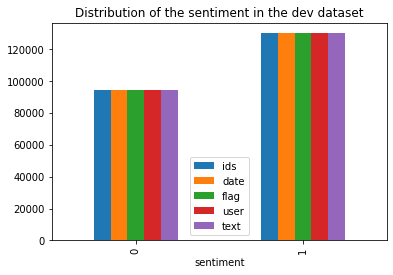

In [144]:
ax = df.groupby('sentiment').count().plot(kind='bar', title = 'Distribution of the sentiment in the dev dataset')
# Slightly unbalanced distribution of data

#### 5 - Data preprocessing and cleaning

#### Remove duplicated tweets

In [145]:
df.drop(df.index[duplicated.index], inplace = True)
df

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...
...,...,...,...,...,...,...
224989,0,2261324310,Sat Jun 20 20:36:48 PDT 2009,NO_QUERY,CynthiaBuroughs,@Dropsofreign yeah I hope Iran people reach fr...
224990,1,1989408152,Mon Jun 01 01:25:45 PDT 2009,NO_QUERY,unitechy,Trying the qwerty keypad
224991,0,1991221316,Mon Jun 01 06:38:10 PDT 2009,NO_QUERY,Xaan,I love Jasper &amp; Jackson but that wig in th...
224992,0,2239702807,Fri Jun 19 08:51:56 PDT 2009,NO_QUERY,Ginger_Billie,I am really tired and bored and bleh! I feel c...


#### 1st try to remove every col except from the text and ids (useful for the submission)

In [146]:
cols_to_hold = df.columns.drop(['date', 'flag'])
df = df[cols_to_hold]

#### 2nd tweets in lowercase

In [147]:
# not sure of the error
df['text'] = df['text'].str.lower()


<ipython-input-147-9ee0ff620fd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.lower()


#### Stop-words, mentions, tags, urlsand punctuation remove

In [148]:
stop_words = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

def clean_tweet(text):
    # for a givent text we replace every @mention with a "" (empty string)
    text_with_no_tags = re.sub("@[A-Za-z0-9_]+","", text)
    
    # NOT SURE!!!!!!!!! --> for a givent text we replace every @mention with a "" (empty string)
    text_with_no_tags_and_hashtags = re.sub("#[A-Za-z0-9_]+","", text_with_no_tags)
    
    # links remove
    text_with_no_tags_and_links = re.sub("((www.[^s]+)|(https?://[^s]+))","",text_with_no_tags_and_hashtags)
    
    # Now, remove punctation
    # string.punctuation gives all the punctuation, including # and @. For this reason, we make this step as the last one
    translator = str.maketrans('', '', string.punctuation)
    text_with_stopwords_only = text_with_no_tags_and_hashtags.translate(translator)

    # for a given text, we read and return all the words (if not stopwords) separated by " "
    return " ".join([word for word in str(text_with_stopwords_only).split() if word not in stop_words])

df['text'] = df['text'].apply(lambda text: clean_tweet(text))

<ipython-input-148-8aeda8ea9392>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda text: clean_tweet(text))


#### Remove repeting chars ?

#### Remove numeric chars ?

#### Tokenization